# Titanic Survivors Noteboook #

*Author: Dennis Adams (dendad@amazon.com) - Sr AWS Technical Instructor. This notebook is free to copy. No warranty expressed or implied for the use of this notebook. Revision Date: 2022-01-18*

This notebook is a personal project inspired by the Amazon SageMaker Data Wrangler demo: https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-getting-started.html which makes use of the Titanic dataset https://www.openml.org/d/40945 - This data set contains the survival status, age, gender, and class (which serves as a proxy for economic status) of passengers aboard the maiden voyage of the RMS Titanic in 1912. For further information about how to use this dataset, have a look at the competition challenge launched by Kaggle - https://www.kaggle.com/c/titanic 

This project will follow the approach of the "Machine Learning Pipeline" (see chapter headings).

## Business Problem ##

RMS Titanic sank in the early morning hours of 15 April 1912 in the North Atlantic Ocean, four days into her maiden voyage from Southampton to New York City. The largest ocean liner in service at the time, Titanic had an estimated 2,224 people on board when she struck an iceberg at around 23:40 (ship's time) on Sunday, 14 April 1912. Her sinking two hours and forty minutes later at 02:20 (ship's time; 05:18 GMT) on Monday, 15 April, resulted in the deaths of more than 1,500 people, making it one of the deadliest peacetime maritime disasters in history. https://en.wikipedia.org/wiki/Sinking_of_the_Titanic

The 1997 Film Titanic https://www.imdb.com/title/tt0120338/ 
is an epic romance and disaster film directed, written, co-produced, and co-edited by James Cameron. Incorporating both historical and fictionalized aspects, it is based on accounts of the sinking of the RMS Titanic, and stars Leonardo DiCaprio and Kate Winslet as members of different social classes who fall in love aboard the ship during its ill-fated maiden voyage.
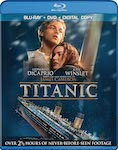

In the film, Jack (Leonardo DiCaprio) dies in the water, and Rose (Kate Winslet) is picked up by a life raft and survives. But would they have survived in real life? The business objective of this project is to build a machine learning model to predict whether Leonardo DiCaprio and Kate Winslet would have survived the Titanic in real life.

This would be a valid Machine Learning problem because of the number of variables (features) involved, such as the class of passenger, age, sex and background. 

## Problem Formulation ##

The goal is to produce a machine learning model which correctly predicts the survival of real people. An accuracy of 90% is the target. Then that model will be applied to the fictional characters from the film to infer whether or not they would have survived in real life.

This would be supervised Learning model., There is a dataset of passengers who survived and those who died on the real Titanic. The "survived" attribute would be the label for the binary classification model.

This notebook will build and train a $\color{red}{\text{binary classification}}$ machine learning model, using the $\color{blue}{\text{Linear Learner}}$ built-in SageMaker algorithm. https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html

## Setup ##

In [1]:
# The import commands for all the python library functions needed.
import io
import csv
import json
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [2]:
# The following logic identifies the default sagemaker bucket, where the CSV file is stored
reg = boto3.session.Session().region_name
acc = boto3.client('sts').get_caller_identity()['Account']
titanic_bucket = 'sagemaker-' + reg + '-' + acc

# Alternatively, enter here the name of your bucket. It must be in the same region.
#titanic_bucket = 'my-bucket-name'

print(titanic_bucket)

sagemaker-eu-west-1-965961791057


*The dataset can be downloaded from here: https://www.openml.org/d/40945 by clicking on the "CSV" icon on the top right of the screen.*

In this case, I have renamed the file to "titanic.csv" for simplicity, and uploaded it into a folder 'Titanic' in my default sagemaker S3 bucket ready for processing. You may need to change the values for 'titanic_bucket' and/or 'load_prefix'/'data_prefix'/'model_prefix' in the followng two cells.

In [3]:
# Folder for the source data, and locations for output data and model
load_prefix = 'Titanic'
data_prefix = 'Titanic/data'
model_prefix = 'Titanic/model'

# Original source file
csv_file ='titanic.csv'

*At this point, all working variables are in place, jump to "Model Training and Tuning" if the data has already been processed and saved to the S3 bucket.*

## Data Collection and Integration ##

In [4]:
# Load the data into Pandas
file_source = 's3://{}/{}/{}'.format(titanic_bucket, load_prefix, csv_file)
titanic = pd.read_csv(file_source)

*It is assumed that this dataset is as complete and as accurate as possible, and that values that are indicated by "?" = unknown or null values can be imputed.*

In [5]:
# Have a brief look at the dataset
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


*The attributes of the dataset are:*
*    Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)      
*    Survived - Survival (0 = No; 1 = Yes).    
*    Name - Name   
*    Sex - Sex       
*    Age - Age   
*    Sibsp - Number of Siblings/Spouses Aboard    
*    Parch - Number of Parents/Children Aboard   
*    Ticket - Ticket Number   
*    Fare - Passenger Fare   
*    Cabin - Cabin   
*    Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [6]:
# what columns are numeric (which may be appropriate for an ML model), 
# and which are categorical 'objects' and will need processing.
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


*There are 1309 records from passengers on the Titanic, the 'survived' feature (the label) and 13 other features that may contribute to the model. The 'age' feature is an 'object' because some rows have a non-numeric text - this will need to be addressed. 'fare' is also an 'object' - it will be necessary to find out why this is not a numeric column.*

In [7]:
titanic.describe(include='all')

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
count,1309.000000,1309.000000,1309,1309,1309,1309.000000,1309.000000,1309,1309,1309,1309,1309,1309,1309
unique,NaN,NaN,1307,2,99,NaN,NaN,929,282,187,4,28,122,370
top,NaN,NaN,"Kelly, Mr. James",male,?,NaN,NaN,CA. 2343,8.05,?,S,?,?,?
freq,NaN,NaN,2,843,263,NaN,NaN,11,60,1014,914,823,1188,564
mean,2.294882,0.381971,NaN,NaN,NaN,0.498854,0.385027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.837836,0.486055,NaN,NaN,NaN,1.041658,0.865560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,1.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*There may be a duplicate 'name' with Mr. James Kelly and also Miss. Kate Connolly. The 'sex' column only has two values, so that can be easily processed. The 'age' column has 99 unique values - that could be processed by binning the ages into several categories such as child/young_adult/adult. The 'embarked' feature could be a feature in the model? There are other features such as 'boat' (which lists the lifeboat people were recovered from) and 'body' (which says whether the body was recovered) that could be dropped from the datasest, since they would not influence the model.*

In [8]:
duplicates = titanic.duplicated()
duplicates.sum()

0

*So there are no duplicates, which means Mr. James Kelly either appears with two lots of information, or maybe there were two people with the same name and different information. Similarly with Miss. Kate Connolly.*

In [9]:
# Check about Mr Kelly
titanic[titanic['name']=='Kelly, Mr. James']

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
924,3,0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,?,Q,?,70,?
925,3,0,"Kelly, Mr. James",male,44,0,0,363592,8.05,?,S,?,?,?


In [10]:
# Check about Miss Connolly
titanic[titanic['name']=='Connolly, Miss. Kate']

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
725,3,1,"Connolly, Miss. Kate",female,22,0,0,370373,7.75,?,Q,13,?,Ireland
726,3,0,"Connolly, Miss. Kate",female,30,0,0,330972,7.6292,?,Q,?,?,Ireland


In [11]:
titanic.isnull().sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home.dest    0
dtype: int64

*No Null entries - that makes life a bit easier*

*However, we do have '?' characters in the dataset, which correspond to nulls instead. The occurrences are as follows:*

In [12]:
print('Occurrences of ? character:')
for col in titanic:
    print('{:14} {}'.format(col, len(titanic[titanic[col] == "?"])))

Occurrences of ? character:
pclass         0
survived       0
name           0
sex            0
age            263
sibsp          0
parch          0
ticket         0
fare           1
cabin          1014
embarked       2
boat           823
body           1188
home.dest      564


## Data Pre-Processing and visualization ##

*Look at the 'survived' feature, which will be the label of the dataset.*

In [13]:
# Check that there is a "balance" between survived and died.
titanic['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

*Drop the 'name' feature.
Also drop the 'boat' and 'body' features since they are not going to influence the model.
The ticket Number and the Cabin Number are unlikely to be influencers either.
(Although it might be worthwhile looking at the cabin number later on?)
Home destination is not interesting at the moment.*

In [14]:
# Drop columns that are not wanted
drop_cols = ['boat', 'body', 'name', 'ticket', 'cabin', 'home.dest']
titanic.drop(drop_cols, axis=1,inplace=True)

In [15]:
# Shuffle around to data to make 'survived' the leading column of the dataset ready for training
titanic = titanic[['survived'] + [col for col in titanic.columns if col != 'survived' ]]
titanic['survived'] = titanic['survived'].astype('int32')

In [16]:
# This is what the data set now looks like:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.55,S
2,0,1,female,2,1,2,151.55,S
3,0,1,male,30,1,2,151.55,S
4,0,1,female,25,1,2,151.55,S


pclass


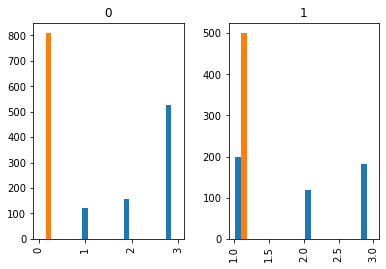

sibsp


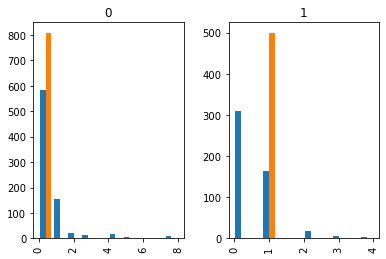

parch


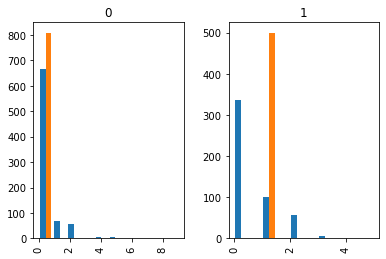

In [17]:
# Do some general visualisations of the relationships of the remaining features to 'survived'
# Firstly the numeric features
for column in titanic.select_dtypes(exclude=['object']).columns:
    if column != 'survived':
        print(column)
        hist = titanic[[column, 'survived']].hist(by='survived')
        plt.show()

In [18]:
# Then also look at the relationships between non-numeric features and 'survived'
for column in titanic.select_dtypes(include=['object']).columns:
    if column != 'survived':
        display(pd.crosstab(
            index=titanic[column], columns=titanic['survived'], normalize='columns'))

survived,0,1
sex,,
female,0.156984,0.678
male,0.843016,0.322


survived,0,1
age,,
0.1667,0.000000,0.002
0.3333,0.001236,0.000
0.4167,0.000000,0.002
0.6667,0.000000,0.002
0.75,0.001236,0.004
...,...,...
76,0.000000,0.002
8,0.002472,0.008
80,0.000000,0.002


survived,0,1
fare,,
0,0.018541,0.004
10.1708,0.001236,0.000
10.4625,0.002472,0.000
10.5,0.028430,0.024
10.5167,0.001236,0.000
...,...,...
9.8458,0.001236,0.000
90,0.001236,0.008
91.0792,0.000000,0.004


survived,0,1
embarked,,
?,0.000000,0.004
C,0.148331,0.300
Q,0.097651,0.088
S,0.754017,0.608


<AxesSubplot:xlabel='embarked', ylabel='survived'>

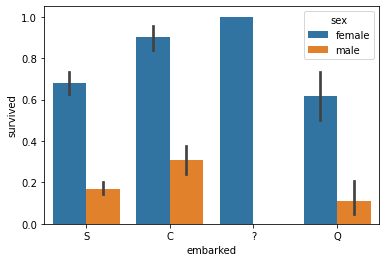

In [19]:
# Some more visualisation: percentage survival rate, depending upon their sex and where they started.
sns.barplot(x="embarked", y="survived", hue="sex", data=titanic)

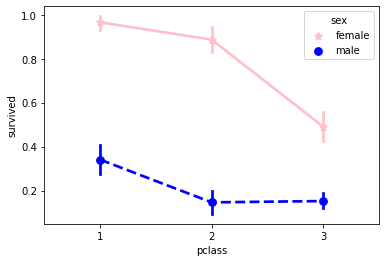

In [20]:
# some more understanding of the survival rates by class:
sns.pointplot(x="pclass", y="survived", hue="sex", data=titanic,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

*'pclass' processing. This is the Passenger Class, which may be a significant feature in the model. Legend has it that first class passengers got off the Titanic, and left third class passengers to die.*

In [21]:
# Passenger Class: Start by looking at the distribution of values. Nothing else to be done.
titanic['pclass'].value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

In [22]:
# Make this an int32
titanic['pclass'] = titanic['pclass'].astype('int32')

*Assuming that women and children were allowed to the lifeboats first, I expect 'sex' to be a significant feature in the model*

In [23]:
# For 'sex', confirm what all the values are.
titanic['sex'].value_counts()

male      843
female    466
Name: sex, dtype: int64

In [24]:
# Use an inline lambda to change "female"/"male" to the values 0/1
# Make it numeric
mapped_sex = {'female':0, 'male':1}
titanic['sex'] = titanic['sex'].map(lambda x: mapped_sex[x]).astype("int32")

*Think about what we can do about 'age'. This may be a significant feature in the model.*

In [25]:
# See what the data distribution of age looks like.
titanic['age'].value_counts()

?       263
24       47
22       43
21       41
30       40
       ... 
70.5      1
80        1
55.5      1
26.5      1
20.5      1
Name: age, Length: 99, dtype: int64

In [26]:
# What to do with all those'?' and '0'
# Since these are 263 records inside a dataset of 1309, it would not be a good idea to discard these rows.
# Instead, use imputation to replace with the mean, or average values.
print('Number of ? rows: {}'.format(len(titanic[titanic['age'] == "?"])))
print('Number of 0 rows: {}'.format(len(titanic[titanic['age'] == "0"])))

Number of ? rows: 263
Number of 0 rows: 0


In [27]:
# Extract the data for the ages that are known, and work out the mean/average ages by sex.
# Assume that the average ages of men and women would differ.
# then use imputation to replace the '?' with the average for that sex
# finally, covert all that text/object data to numbers.
# 
# Extract the age and sex columns from the part of the dataset having numeric ages
known_ages = titanic[['age','sex']] 
known_ages = known_ages[(known_ages['age']!='?')]

In [28]:
# Convert the column to numeric
known_ages = known_ages.astype ({"age": "float32"})

In [29]:
known_ages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 0 to 1308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     1046 non-null   float32
 1   sex     1046 non-null   int32  
dtypes: float32(1), int32(1)
memory usage: 16.3 KB


In [30]:
# calculate the mean age grouped by sex
mean_ages = known_ages.groupby('sex')['age'].mean()
mean_ages

sex
0    28.687071
1    30.585234
Name: age, dtype: float32

In [31]:
# Define a function to replace '?' with the appropriate average.
def update_ages(age,sex):
    if age == '?' and sex == 0:
        age = mean_ages[0].astype("str")
    elif age == '?' and sex == 1:
        age = mean_ages[1].astype("str")
    return age

In [32]:
# Apply this function to get all the ages, then convert the feature to numeric
titanic['age'] = titanic.apply(lambda x: update_ages(x['age'], x['sex']), axis=1)
titanic['age'] = titanic['age'].astype('float32').round(decimals=2)
titanic['age'].value_counts()

30.590000    185
28.690001     78
24.000000     47
22.000000     43
21.000000     41
            ... 
23.500000      1
70.500000      1
26.500000      1
11.500000      1
60.500000      1
Name: age, Length: 100, dtype: int64

<AxesSubplot:>

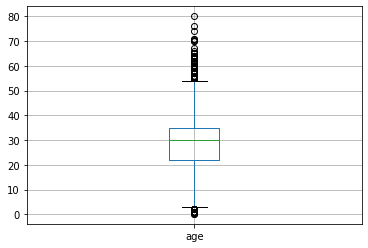

In [33]:
# Visualize the age distribution using a box plot
titanic.boxplot(['age'])

<AxesSubplot:ylabel='Frequency'>

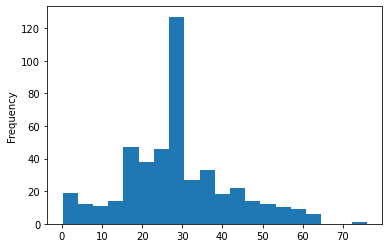

In [34]:
# For completeness, visualise the histogram of distribution of ages 
# Start with women...
titanic[titanic['sex']==0]["age"].plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

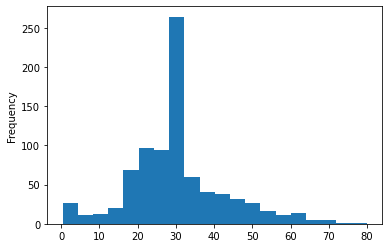

In [35]:
# and visualize the distribution of ages for men
titanic[titanic['sex']==1]["age"].plot.hist(bins=20)

*At this stage, keep ages as numeric values, rather than doing "binning". But that might be something to consider for a future iteration of the model*


*Now think about the impact of siblings and parents. Intuitively, this could be a factor in whether or not someone survived, since families would stick together and may be more likely to find a lifeboat.*

sibsp
parch


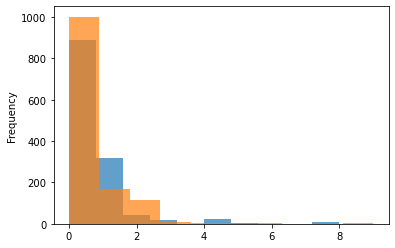

In [36]:
# Start by looking at the distribution of these features.
for col in ['sibsp', 'parch']:
    print(col)
    titanic[col].plot.hist(alpha=0.7) 

In [37]:
# Look at the distribution of siblings
titanic['sibsp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64

In [38]:
# And distribution of parents and children
titanic['parch'].value_counts()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: parch, dtype: int64

In [39]:
# Recast these as int32
titanic['sibsp'] = titanic['sibsp'].astype('int32')
titanic['parch'] = titanic['parch'].astype('int32')

*Fare may be in influencer - people paying more may get priority on the lifeboats.*

In [40]:
# So keep this in the model
titanic['fare'].value_counts()

8.05      60
13        59
7.75      55
26        50
7.8958    49
          ..
8.3        1
?          1
8.4333     1
6.45       1
9.6875     1
Name: fare, Length: 282, dtype: int64

In [41]:
titanic['fare'].isnull().values.any()

False

In [42]:
# some people paid nothing?
# Need to account for these as well...
titanic[titanic['fare']=='0']

,survived,pclass,sex,age,sibsp,parch,fare,embarked
7,0,1,1,39.00,0,0,0,S
70,0,1,1,30.59,0,0,0,S
125,0,1,1,30.59,0,0,0,S
150,0,1,1,40.00,0,0,0,S
170,1,1,1,49.00,0,0,0,S
223,0,1,1,30.59,0,0,0,S
234,0,1,1,38.00,0,0,0,S
363,0,2,1,30.59,0,0,0,S
384,0,2,1,30.59,0,0,0,S
410,0,2,1,30.59,0,0,0,S


In [43]:
titanic[titanic['fare']=='0'].count()

survived    17
pclass      17
sex         17
age         17
sibsp       17
parch       17
fare        17
embarked    17
dtype: int64

In [44]:
# Looks like there are some strange characters in this 'fare' features, so need to identify them.
titanic[titanic['fare']=='?']

,survived,pclass,sex,age,sibsp,parch,fare,embarked
1225,0,3,1,60.5,0,0,?,S


In [45]:
# Replace with the average fare for that class.
# It would be possible to drop these rows, but prefer not to lose anything from the small dataset.
# Also get the zero fares out of the way.
# pull out the subset of fares by class to calculate the average
known_fares = titanic[['fare','pclass']]
known_fares = known_fares[(known_fares['fare']!='?') & (known_fares['fare']!='0')]
known_fares['fare'] = known_fares['fare'].astype("float32")
known_fares.count()

fare      1291
pclass    1291
dtype: int64

In [46]:
# calculate the average for each class.
mean_fare = known_fares.groupby('pclass')['fare'].mean()
mean_fare

pclass
1    89.447479
2    21.648109
3    13.378473
Name: fare, dtype: float32

In [47]:
# Define a function to process this
def update_fare(fare, pclass):
    if fare == '?' or fare == '0':
        fare = str(mean_fare[pclass])
    return fare

# Then do the replacement and covert all to floats with 2 decimal places.
titanic['fare'] = titanic.apply(lambda x: update_fare(x['fare'],x['pclass']), axis=1)
titanic['fare'] = titanic['fare'].astype('float32').round(decimals=3)

<AxesSubplot:ylabel='Frequency'>

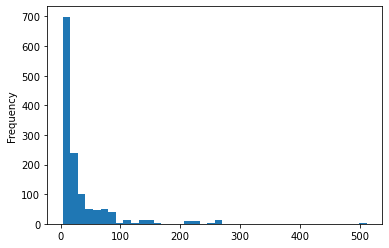

In [48]:
titanic['fare'].plot.hist(bins=40)

*Would it make a difference where you joined the Titanic? This may be unlikely - but the correlation matrix above suggests that people joining in Southampton are more likely to not survive. So use this data in the model.*

In [49]:
# Firstly, looking at the distribution of values
titanic['embarked'].value_counts()

S    914
C    270
Q    123
?      2
Name: embarked, dtype: int64

In [50]:
# There are two stowaways !
titanic[titanic['embarked']=='?']

,survived,pclass,sex,age,sibsp,parch,fare,embarked
168,1,1,0,38.0,0,0,80.0,?
284,1,1,0,62.0,0,0,80.0,?


In [51]:
# Assume they got on board at Cherbourg
# .. which is where the story begins.
def update_embarked(embarked):
    if embarked=='?':
        embarked='C'
    return embarked

titanic['embarked']= titanic.apply(lambda x: update_embarked(x['embarked']),axis=1)
titanic['embarked'].value_counts()

S    914
C    272
Q    123
Name: embarked, dtype: int64

In [52]:
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.00,0,0,211.337997,S
1,1,1,1,0.92,1,2,151.550003,S
2,0,1,0,2.00,1,2,151.550003,S
3,0,1,1,30.00,1,2,151.550003,S
4,0,1,0,25.00,1,2,151.550003,S
5,1,1,1,48.00,0,0,26.549999,S
6,1,1,0,63.00,1,0,77.958000,S
7,0,1,1,39.00,0,0,89.446999,S
8,1,1,0,53.00,2,0,51.479000,S
9,0,1,1,71.00,0,0,49.504002,C


In [53]:
titanic.dtypes

survived      int32
pclass        int32
sex           int32
age         float32
sibsp         int32
parch         int32
fare        float32
embarked     object
dtype: object

In [54]:
# Now do one-hot encoding on the 'embarked' feature
# this will create three new features embarked_S, embarked_C and embarked_Q
embarked_data = pd.get_dummies(titanic['embarked'],prefix='embarked',dtype='int32')
embarked_data.head()

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [55]:
# drop the old column and append the new ones on the end
titanic.drop('embarked', axis=1,inplace=True)
titanic = pd.concat([titanic, embarked_data], axis=1)
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.00,0,0,211.337997,0,0,1
1,1,1,1,0.92,1,2,151.550003,0,0,1
2,0,1,0,2.00,1,2,151.550003,0,0,1
3,0,1,1,30.00,1,2,151.550003,0,0,1
4,0,1,0,25.00,1,2,151.550003,0,0,1


Completed all the data cleansing and feature engineering.

In [56]:
# Now all the features are in numerical format.
titanic.dtypes

survived        int32
pclass          int32
sex             int32
age           float32
sibsp           int32
parch           int32
fare          float32
embarked_C      int32
embarked_Q      int32
embarked_S      int32
dtype: object

In [57]:
# Check that everything is in a suitable format:
titanic.describe(include='all')

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.381971,2.294882,0.644003,29.910330,0.498854,0.385027,33.898701,0.207792,0.093965,0.698243
std,0.486055,0.837836,0.478997,12.889228,1.041658,0.865560,51.779980,0.405882,0.291891,0.459196
min,0.000000,1.000000,0.000000,0.170000,0.000000,0.000000,3.171000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,30.000000,0.000000,0.000000,14.500000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.388000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.328979,1.000000,1.000000,1.000000


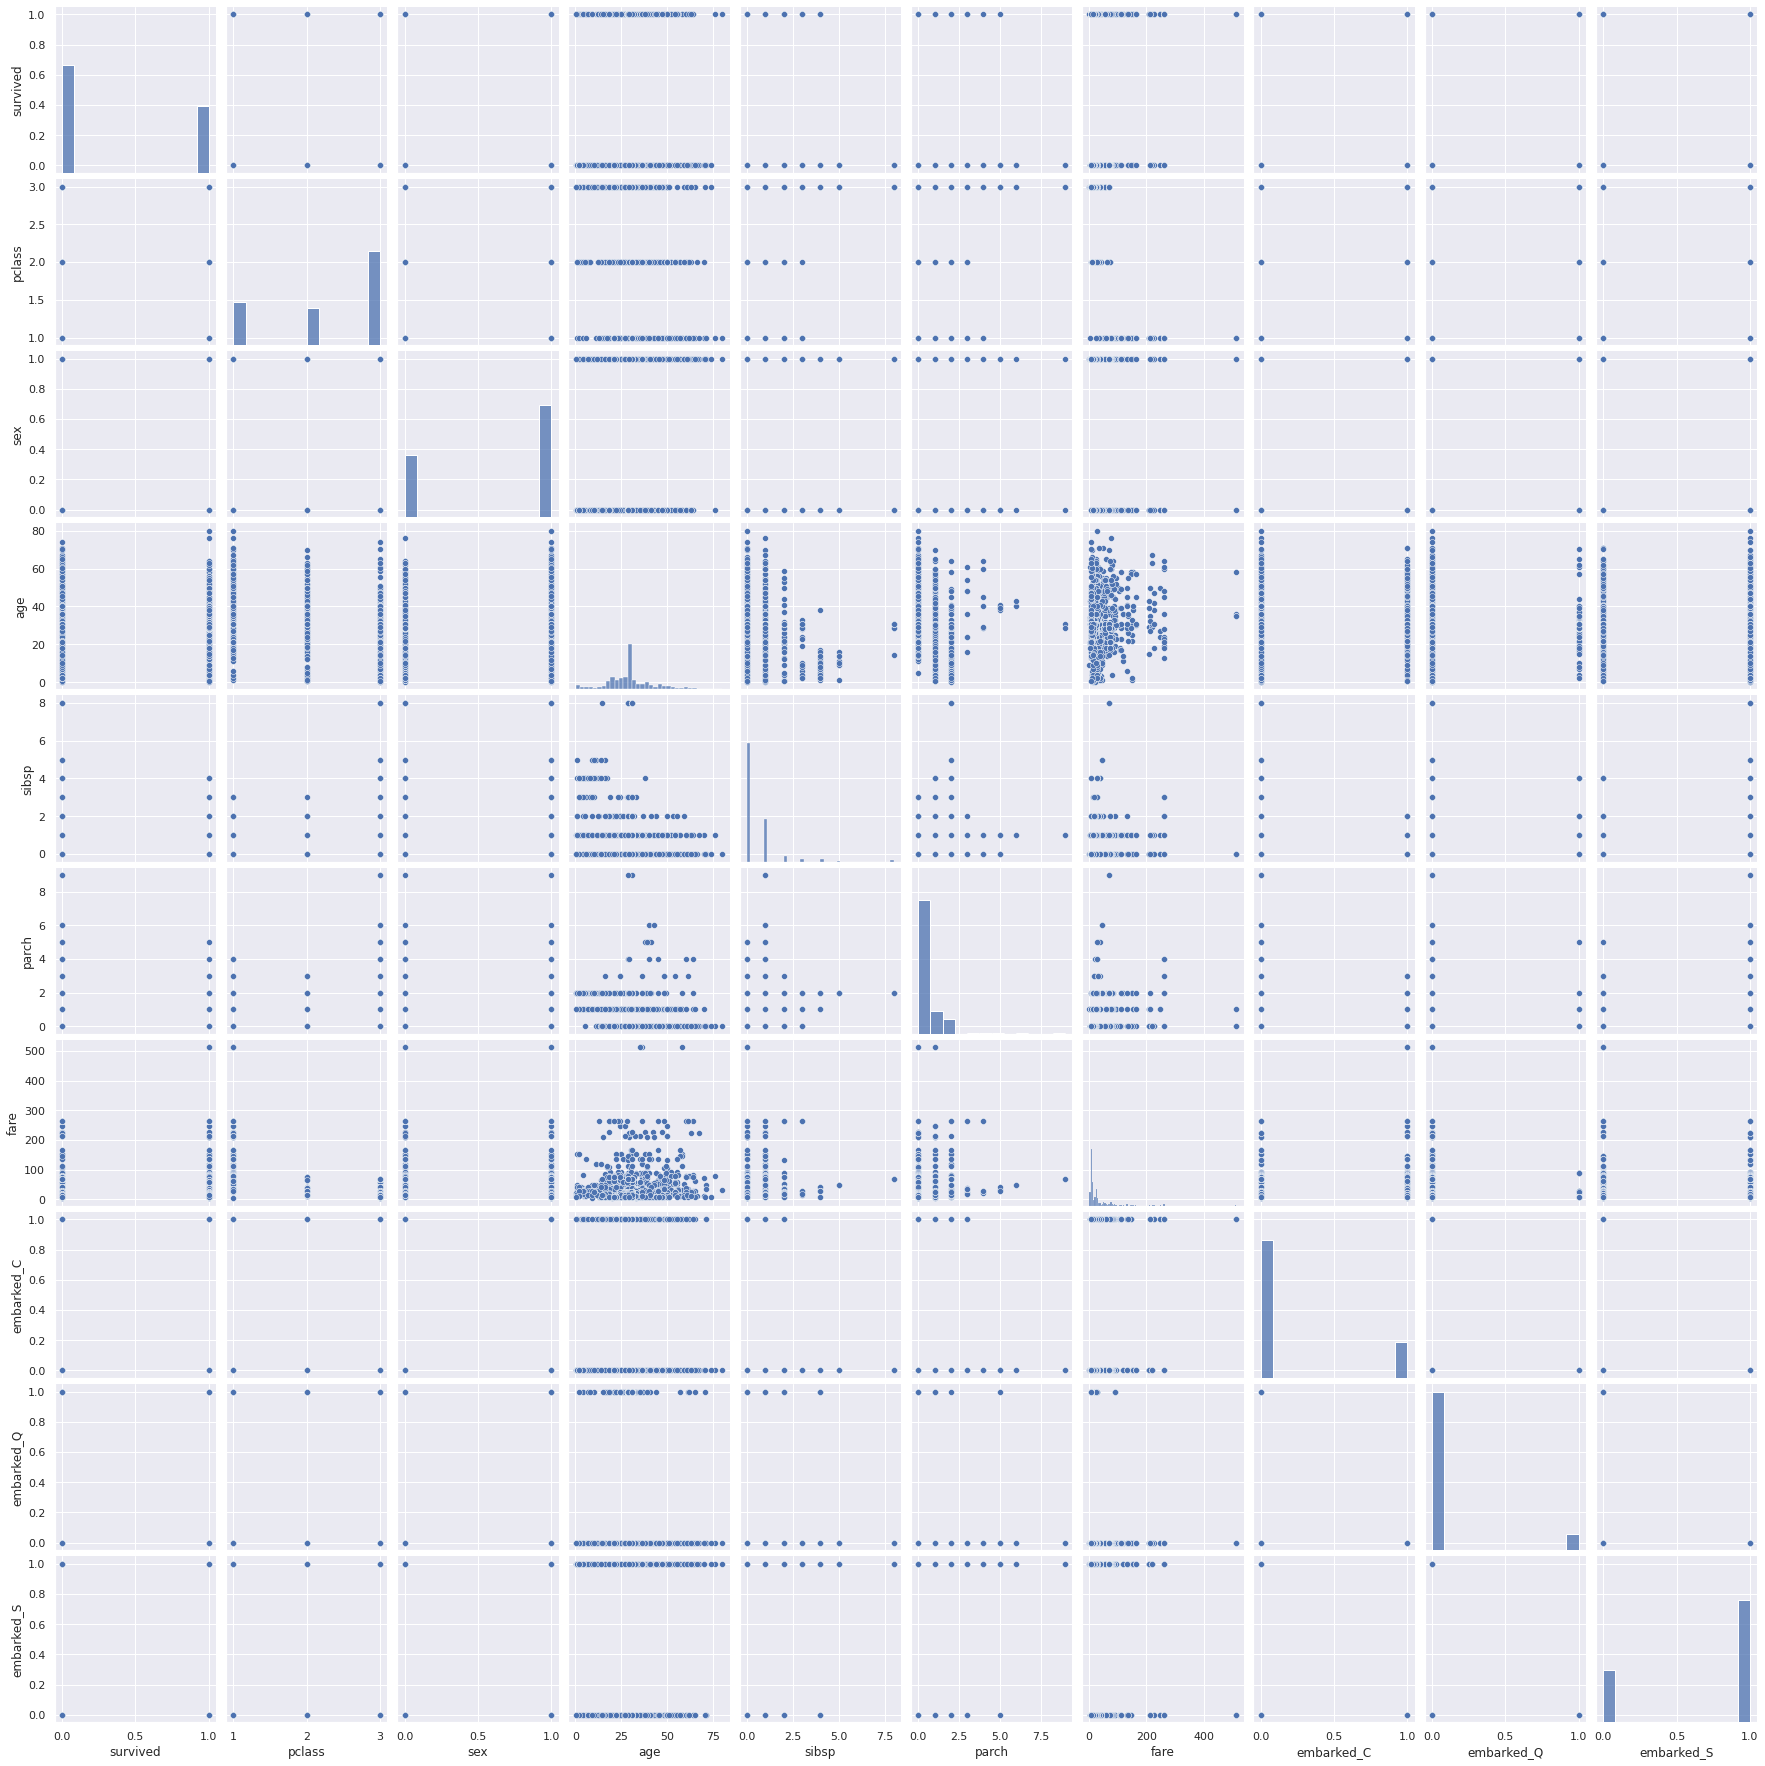

In [58]:
# So have a look at the correlation of features.
# Are there any highly correlated features which need to be removed from the model?
sns.set(style="darkgrid", context="notebook")
sns.pairplot(titanic)

In [59]:
# Build a correlation matrix
corr = titanic.corr()
corr.style.background_gradient(cmap='coolwarm')

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
survived,1.000000,-0.312469,-0.528693,-0.056540,-0.027825,0.082660,0.237976,0.186418,-0.016071,-0.154558
pclass,-0.312469,1.000000,0.124617,-0.365646,0.060832,0.018322,-0.572581,-0.274746,0.230491,0.096335
sex,-0.528693,0.124617,1.000000,0.070561,-0.109609,-0.213125,-0.176672,-0.071447,-0.088651,0.119504
age,-0.056540,-0.365646,0.070561,1.000000,-0.193650,-0.133658,0.174215,0.082499,-0.016826,-0.062225
sibsp,-0.027825,0.060832,-0.109609,-0.193650,1.000000,0.373587,0.154514,-0.050068,-0.048678,0.075198
parch,0.082660,0.018322,-0.213125,-0.133658,0.373587,1.000000,0.216161,-0.010287,-0.100943,0.073258
fare,0.237976,-0.572581,-0.176672,0.174215,0.154514,0.216161,1.000000,0.282665,-0.133704,-0.164856
embarked_C,0.186418,-0.274746,-0.071447,0.082499,-0.050068,-0.010287,0.282665,1.000000,-0.164932,-0.779058
embarked_Q,-0.016071,0.230491,-0.088651,-0.016826,-0.048678,-0.100943,-0.133704,-0.164932,1.000000,-0.489874
embarked_S,-0.154558,0.096335,0.119504,-0.062225,0.075198,0.073258,-0.164856,-0.779058,-0.489874,1.000000


<AxesSubplot:>

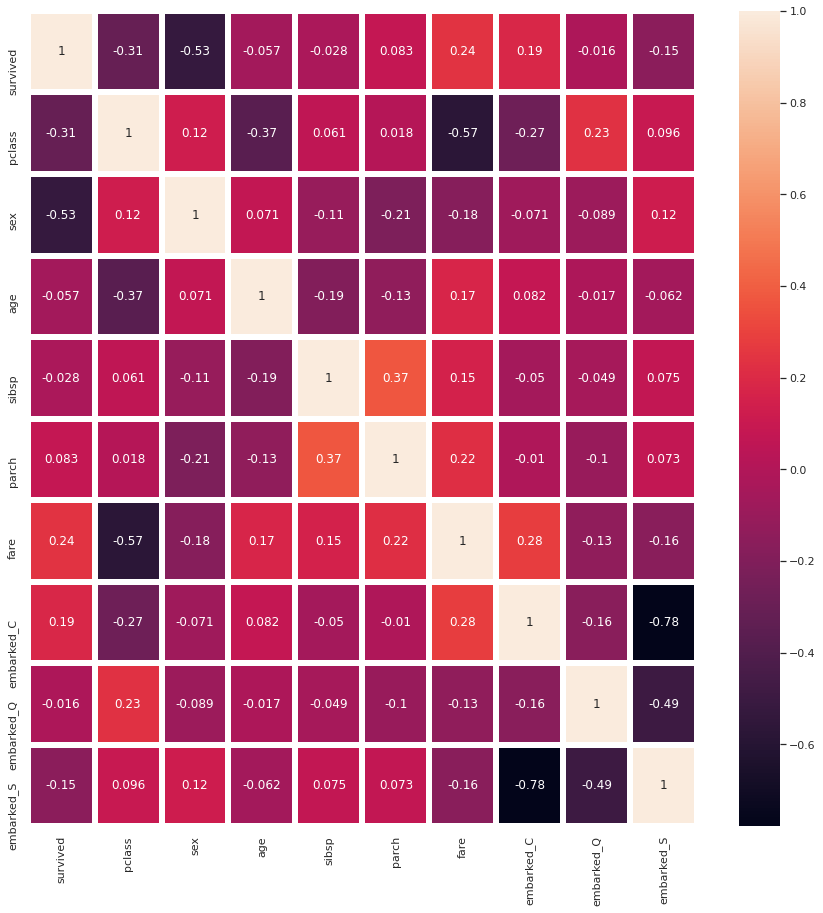

In [60]:
# and a heatmap to help visualize the relationships
plt.figure(figsize=[15,15])
sns.heatmap(titanic.corr(), linewidths=5, annot=True)

*All the data is now in float32 or int32 format, and structured ready for the training phase. The first column 'survived' is the label for the supervised learning model. For completeness, save this to S3: this means the model training can be re-run from this point at any time.*

In [61]:
# Save the cleaned data to S3.
file_target = 's3://{}/{}/titanic_processed.csv'.format(titanic_bucket, data_prefix)
titanic.to_csv(file_target, index= False)

## Model Training and Tuning ##

*Start by reading the cleaned data from S3*

In [62]:
# Read the cleaned data off S3 ready to present it to the model.
file_source = 's3://{}/{}/titanic_processed.csv'.format(titanic_bucket, data_prefix)
titanic_processed = pd.read_csv(file_source)

In [63]:
# quick check of what we have...
titanic_processed.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.00,0,0,211.338,0,0,1
1,1,1,1,0.92,1,2,151.550,0,0,1
2,0,1,0,2.00,1,2,151.550,0,0,1
3,0,1,1,30.00,1,2,151.550,0,0,1
4,0,1,0,25.00,1,2,151.550,0,0,1


In [64]:
# Get the target column (outputs) or label from the first column
y = titanic_processed.values[:, 0].astype(np.float32)

# Get the feature values (inputs) except for the label column
X = titanic_processed.values[:,1:].astype(np.float32)

In [65]:
print(f"Shape of y (the labels)  : {y.shape}")
print(f"Shape of X (the features): {X.shape}") 

Shape of y (the labels)  : (1309,)
Shape of X (the features): (1309, 9)


In [66]:
# Seed the random shuffling of data
np.random.seed(8675309)

# Get 80% of the data for training; the remaining 20% will be for validation and test
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2,shuffle=True)

# Split the remaining 20% of data as 50% test and 50% validation
test_features, val_features, test_labels, val_labels = train_test_split(
    test_features, test_labels, test_size=0.5,shuffle=True)

print(f"Shape of train_features is: {train_features.shape}") 
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Shape of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Shape of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Shape of train_features is: (1047, 9)
Length of train_labels is: (1047,)
Shape of val_features is: (131, 9)
Length of val_labels is: (131,)
Shape of test_features is: (131, 9)
Length of test_labels is: (131,)


*The SageMaker Linear Learner estimator object is a supervised learning algorithms used for solving classification or regression problems.*

*For input, you give the model labeled examples (x, y). x is a high-dimensional vector and y is a numeric label. For binary classification problems, the label must be either 0 or 1. For multiclass classification problems, the labels must be from 0 to num_classes - 1. For regression problems, y is a real number. The algorithm learns a linear function, or, for classification problems, a linear threshold function, and maps a vector x to an approximation of the label y*

*Ref: https://sagemaker.readthedocs.io/en/stable/algorithms/linear_learner.html*

In [69]:
# Define the SageMaker LinearLearner estimator object to train the model
binary_estimator = sagemaker.LinearLearner(
    #
    # Security requires an IAM role
    role=sagemaker.get_execution_role(),
    #
    # Set the Hyperparameters for the LinearLearner algorithm
    # Configure as a 'binary classifier', to return '0' (died), '1' (survived)
    # Run through the test data 20 times (epochs)
    # Stop early if we have converged to a stable minimum
    predictor_type='binary_classifier',
    epochs=20,
    early_stopping_patience=3,
    #
    # Define the runtime environment to train the model in the cloud
    # Execute the training in the AWS Cloud using a single m4.xlarge instance.
    instance_count=1,
    instance_type='ml.m4.xlarge', 
    #
    # Add configuration settings for this training job.
    base_job_name='Titanic',
    #
    # Being Frugal, we will use SPOT instances for this, with a 20 minute waiting time.
    # Define a cutoff of 15 minutes for the job
    # And an S3 bucket to hold a checkpoint in case of early termination
    use_spot_instances=True,
    max_run=900,
    max_wait=1200,
    checkpoint_s3_uri='s3://{}/{}/checkpoint/'.format(titanic_bucket, data_prefix),
    #
    # Define the output bucket for the resulting model
    output_path='s3://{}/{}/'.format(titanic_bucket, model_prefix)
)

In [70]:
### There are several ways of delivering the data to the Linear Learner model. 
# The first way is to pass the numpy arrays in memory directly to Linear Learner
# ... so nothing to do here...

# Another way is to save this as CSV, without headers, load into S3, 
# and then pass the CSV file locations in S3 to Linear Learner
#
pd.concat([pd.DataFrame(train_labels), pd.DataFrame(train_features)],axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([pd.DataFrame(val_labels), pd.DataFrame(val_features)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([pd.DataFrame(test_labels), pd.DataFrame(test_features)], axis=1).to_csv('test.csv', index=False, header=False)

s3=boto3.Session().resource('s3')
s3.Bucket(titanic_bucket).upload_file('train.csv','{}/train/train.csv'.format(data_prefix))
s3.Bucket(titanic_bucket).upload_file('validation.csv','{}/validation/validation.csv'.format(data_prefix))
s3.Bucket(titanic_bucket).upload_file('test.csv','{}/test/test.csv'.format(data_prefix))

# Another way is to reformat these as protobuf files, load into S3, 
# and then pass the protobuf file locations in S3 to Linear Learner
#
#train_file = 'train.rec'
#f = io.BytesIO()
#write_numpy_to_dense_tensor(f, train_features.astype(np.float32), train_labels.astype(np.float32))
#f.seek(0)
#boto3.Session().resource('s3').Bucket(titanic_bucket).Object('{}/train/{}'.format(data_prefix, train_file)).upload_fileobj(f)
#validation_file = 'validation.rec'
#f = io.BytesIO()
#write_numpy_to_dense_tensor(f, val_features.astype(np.float32), val_labels.astype(np.float32))
#f.seek(0)
#boto3.Session().resource('s3').Bucket(titanic_bucket).Object('{}/validation/{}'.format(data_prefix, validation_file)).upload_fileobj(f)
#test_file = 'test.rec'
#f = io.BytesIO()
#write_numpy_to_dense_tensor(f, test_features.astype(np.float32), test_labels.astype(np.float32))
#f.seek(0)
#boto3.Session().resource('s3').Bucket(titanic_bucket).Object('{}/test/{}'.format(data_prefix, test_file)).upload_fileobj(f)


*When defining the record sets to use, including the Test dataset ensures that Amazon SageMaker will also do automated testing of the model once the learning process has completed. This also enables us to extract Accuracy, Precision and Recall from CloudWatch.*

In [71]:
# The following code would be used to pass the numpy arrays in memory to Linear Learner
#
train_records = binary_estimator.record_set(train_features, train_labels, channel='train')
val_records = binary_estimator.record_set(val_features, val_labels, channel='validation')
test_records = binary_estimator.record_set(test_features, test_labels, channel='test')

# The following code would be used to pass the CSV format files in S3 to Linear Learner
#
#s3_csv_train = 's3://{}/{}/train/train.csv'.format(titanic_bucket, data_prefix)
#s3_csv_validation = 's3://{}/{}/validation/validation.csv'.format(titanic_bucket, data_prefix)
#s3_csv_test = 's3://{}/{}/test/test.csv'.format(titanic_bucket, data_prefix)
#s3_input_train = sagemaker.inputs.TrainingInput( s3_data=s3_csv_train, content_type='text/csv')
#s3_input_validation = sagemaker.inputs.TrainingInput( s3_data=s3_csv_validation, content_type='text/csv')
#s3_input_test = sagemaker.inputs.TrainingInput( s3_data=s3_csv_test, content_type='text/csv')

# The following code would be used to pass the protobuf file locations in S3 to Linear Learner
#
#s3_input_train = sagemaker.inputs.TrainingInput(
#    s3_data='s3://{}/{}/train/'.format(titanic_bucket, data_prefix),
#    content_type='application/x-recordio-protobuf')
#s3_input_validation = sagemaker.inputs.TrainingInput(
#    s3_data='s3://{}/{}/validation/'.format(titanic_bucket, data_prefix),
#    content_type='application/x-recordio-protobuf')
#s3_input_test = sagemaker.inputs.TrainingInput(
#    s3_data='s3://{}/{}/test/'.format(titanic_bucket, data_prefix),
#    content_type='application/x-recordio-protobuf')


In [72]:
# Now train the model, by fitting together the Estimator above, and the inputs.
# The following code references the numpy arrays in memory for Linear Learner
#
binary_estimator.fit([train_records, val_records, test_records])

# The following code references the CSV file locations in S3 for Linear Learner.
#
# binary_estimator.fit({"train": s3_input_train, "validation": s3_input_validation, "test": s3_input_test })

# The following code references the protobuf file locations in S3 for Linear Learner
#
# binary_estimator.fit({"train": s3_input_train, "validation": s3_input_validation, "test": s3_input_test})

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-01-18 09:34:01 Starting - Starting the training job...
2022-01-18 09:34:25 Starting - Launching requested ML instancesProfilerReport-1642498441: InProgress
......
2022-01-18 09:35:25 Starting - Preparing the instances for training.........
2022-01-18 09:36:50 Downloading - Downloading input data...
2022-01-18 09:37:28 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/18/2022 09:37:32 INFO 139819440334656] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_b

In [47]:
# Use SageMaker Analytics to fetch training curve data from CloudWatch Metrics
# for this training job.
sagemaker.analytics.TrainingJobAnalytics(
    binary_estimator._current_job_name,
    metric_names=['train:objective_loss', 'validation:objective_loss', 'test:objective_loss', 
                  'validation:binary_classification_accuracy', 'test:binary_classification_accuracy', 
                  'validation:recall', 'test:recall', 
                  'validation:precision', 'test:precision', 
                  'validation:roc_auc_score', 'test:roc_auc_score']
    ).dataframe()

,timestamp,metric_name,value
0,0.0,train:objective_loss,0.631695
1,0.0,validation:objective_loss,0.637643
2,0.0,test:objective_loss,0.339135
3,0.0,validation:binary_classification_accuracy,0.793893
4,0.0,test:binary_classification_accuracy,0.816794
5,0.0,validation:recall,0.784314
6,0.0,test:recall,0.928571
7,0.0,validation:precision,0.714286
8,0.0,test:precision,0.650000
9,0.0,validation:roc_auc_score,0.836029


*For the first run of this model, there are reasonable values for accuracy and recall.*

## Model Evaluation ##

#### Deployment for production ####

In [48]:
# Deploy the model using SageMaker, to give us an HTTPS REST API endpoint
# Use a small instance for this - in this case a t2.medium
# But in practice we could build an auto-scaling group.
deployed_model = binary_estimator.deploy( 
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='titanic-survivors-endpoint',
    model_name='titanic-survivors-model')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------!

#### Model Evaluation Using Test Data  ####
*We have some testing data available, so cycle through this to see how well the model behaves*

In [49]:
# Function to get predictions for each batch with size of 10
# Report on the key metrics and create a confusion matrix.
# For binary classification, round the predictions to zero decimal places
def predict_regression_batches(predictor, features, labels):
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(features, 10)]
    
    # Parse protobuf responses to extract predicted labels
    extract_score = lambda x: x.label['score'].float32_tensor.values
    preds = np.concatenate([np.array([extract_score(x) for x in batch]) for batch in prediction_batches])
    preds = preds.reshape((-1,)).round(decimals=0)
    
    # useful information:
    print(f'No of Labels: {len(labels)}')
    print(f'Positive Actuals {len(labels[labels == 1]  )}')
    print(f'Negative Actuals {len(labels[labels != 1]    )}')

    print(f'No of Predictions: {len(preds)}')
    print(f'Positive Predictions {len(preds[(preds) == 1]  )}')
    print(f'Negative Predictions {len(preds[(preds) != 1]  )}')
    
    #print(f'Labels: {labels}')
    #print(f'Preds: {preds}')
    print('')
    
    # Calculate mean squared error
    mse = sum((preds - labels)**2) / len(preds)
    print(f'Mean Square Error: {mse}')
  
    # Calculate accuracy, precision, and recall
    accuracy = 100*((preds == labels).sum() / len(labels))
    print('Accuracy: {:0.3f} %'.format(accuracy))
    
    # Calculate precision
    precision = 100*((preds[preds == 1] == labels[preds == 1]).sum() / len(preds[preds == 1]))
    print('Precision: {:0.3f} %'.format(precision))
    
    # Calculate recall
    recall = 100*(preds[preds == 1] == labels[preds == 1]).sum() / len(labels[labels == 1])
    print('Recall: {:0.3f} %'.format(recall))
    
    # And plot a confusion matrix
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['Actuals'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 

No of Labels: 131
Positive Actuals 42
Negative Actuals 89
No of Predictions: 131
Positive Predictions 54
Negative Predictions 77

Mean Square Error: 0.183206106870229
Accuracy: 81.679 %
Precision: 66.667 %
Recall: 85.714 %


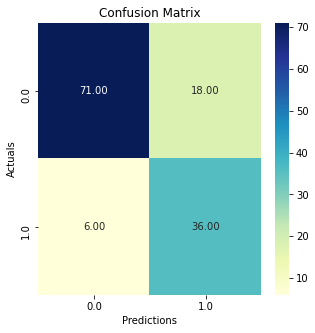

In [50]:
# batch predictions using the test data
test_predictions = predict_regression_batches(deployed_model, test_features, test_labels)

#### Prepare Testing Interface ####

In [51]:
# create the interface to the sagemaker runtime
# this allows us to call the REST api directly
sagemaker_runtime = boto3.client('sagemaker-runtime')

In [52]:
# Process actual case studies by sending in an array of variables for inferencing.
# Define a function to format the parameters into protobuf format and call the endpoint.
# Return the JSON structure predictions
def predict_survivor(paramarray):
    print("processing input")
    ar = np.array(paramarray).astype("float32").reshape(1,9)
    buf=io.BytesIO()
    write_numpy_to_dense_tensor(buf,ar)
    buf.seek(0)
    
    print("calling endpoint")
    response = sagemaker_runtime.invoke_endpoint(
        EndpointName='titanic-survivors-endpoint',
        ContentType='application/x-recordio-protobuf',
        Accept='application/json',
        Body=buf)

    print("response found")
    pred= json.loads(response['Body'].read().decode('UTF-8'))
    return pred['predictions']

#### Case Study: Molly Brown ####
Margaret ("Molly") Brown (née Tobin; July 18, 1867 – October 26, 1932), posthumously known as "The Unsinkable Molly Brown", was an American socialite and philanthropist. She unsuccessfully encouraged the crew in Lifeboat No. 6 to return to the debris field of the 1912 sinking of RMS Titanic to look for survivors. During her lifetime, her friends called her "Maggie", but even by her death, obituaries referred to her as the "Unsinkable Molly Brown". 
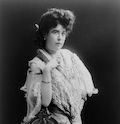
Reference: https://en.wikipedia.org/wiki/Margaret_Brown

In [53]:
# Ask the model to predict that Molly survived.
molly=predict_survivor([1,0,44,0,0,27.7208,1,0,0])

processing input
calling endpoint
response found


In [54]:
print(molly)

[{'score': 0.9420389533042908, 'predicted_label': 1}]


*The model predicts with a high score that Molly would have survived*

#### Case Study: John Jacob Astor IV ####
John Jacob "Jack" Astor IV (July 13, 1864 – April 15, 1912) was an American business magnate, real estate developer, investor, writer, lieutenant colonel in the Spanish–American War, and a prominent member of the Astor family.
Astor died in the sinking of RMS Titanic during the early hours of April 15, 1912. Astor was the richest passenger aboard the RMS Titanic and was thought to be among the richest people in the world at that time with a net worth of roughly USD 87 million when he died (equivalent to USD 2.3 billion in 2019)
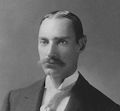
Reference: https://en.wikipedia.org/wiki/John_Jacob_Astor_IV

In [55]:
# Ask the model to predict that John Astor died.
john=predict_survivor([1,1,47,1,0,227.525,1,0,0])

processing input
calling endpoint
response found


In [56]:
print(john)

[{'score': 0.30355072021484375, 'predicted_label': 1}]


*This model actually predicts that John Astor would have survived, although the confidence score is quite low.*

## Evaluation of Business Goal ##

This is where we look at Hollywoods story, and get our model to predict the likely outcome.

#### Case Study: Jack Dawson (Leonardo di Caprio) ####
Jack Dawson (born 1892-1912) is the deuteragonist in Titanic and the love interest of Rose DeWitt Bukater. He dies at the end of the film from hypothermia, protecting Rose by having her float on a doorframe while he stays in the water; he was only twenty years old. He is portrayed by Leonardo DiCaprio.
Jack Dawson boarded the RMS Titanic on April 10, 1912. He was a poor third-class artist and was able to board the ship only after winning tickets in a lucky game of poker against two Swedish men with tickets and playing with his friend, Fabrizio De Rossi.
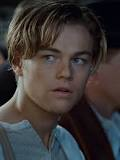
Ref: https://jamescameronstitanic.fandom.com/wiki/Jack_Dawson

In [57]:
# See if the model predicts that Jack Dawson would have survived.
leonardo=predict_survivor([3,1,20,0,0,13.38,0,0,1])

processing input
calling endpoint
response found


In [58]:
print(leonardo)

[{'score': 0.09226738661527634, 'predicted_label': 0}]


*This model correctly predicts that Jack would have died, although the confidence score is fairly low.*

#### Case Study: Rose DeWitt Bukater (Kate Winslet) ####
Rose Calvert (née DeWitt-Bukater, born 1895) was an American socialite and later actress. She was born in Philadelphia in 1895, but her exact birthdate is unknown.
On Wednesday April 10th 1912, Rose boarded the luxurious RMS Titanic in Southampton, England, at the age of 17 with her mother and her aristocratic fiancé Caledon Hockley. The trio were going home to Philadelphia, PA, in America, so Rose and Cal could get married. 
However, during the voyage she and third-class passenger Jack Dawson fell in love.
The voyage came to an abrupt end when the ship struck ice and sank. Rose survived the ship's sinking, but Jack did not.
She later married a man called Calvert, and had at least two children.
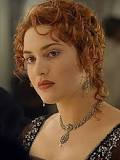
Ref: https://jamescameronstitanic.fandom.com/wiki/Rose_DeWitt_Bukater

In [59]:
# See if the model predicts that Rose would have survived.
kate=predict_survivor([1,0,17,0,1,89.45,0,0,1])

processing input
calling endpoint
response found


In [60]:
print(kate)

[{'score': 0.9561268091201782, 'predicted_label': 1}]


*This model correctly predicts that Rose would have survived, with a high confidence score*

# Conclusion #

In terms of the Business Objective, there is a working model that does correctly predict that Jack (Leonardo DiCaprio) would have died on the Titanic, and Rose (Kate Winslet) would have survived if they had both really been on it in 1912.

This notebook illustrates a range of different techniques for data processing and building a Machine Learning Model. However, the process is always iterative, and there a number of next steps which could be considered.

## Possible Next Steps ##

* Ages are fairly large numeric values: it may be better to bin these into child / young adult / adult / retired etc. rather than using a large numeric value which could bias the model.
* The fare of '?' was replaced by the average for that class, and the '0' fares were also replaced with the average for that class: they could be replaced by the average for that class from that port of embarkation.
* The hyperparameters are only guessswork: run a hyperparameter tuning job on this model. 
* Probabilities may be more realistic than binary surivived/died: consider using linear learner as a regression model, looking at the probabilites of survival, rather than a binary classification.
* The algorithm may not be ideal: try replacing this with XGBoost to see if it is a better model.
* Cabins have not been included: consider using a binning approach to indicate where on the ship people were living, as a feature to impact whether they survived.
* Destination has not been included: consider whether this is a feature.
* It is not clear what features are relevant: look at Principle Component Analysis to see which features could be dropped.

## SageMaker Studio Services to look at ##

* SageMaker Data Wrangler to automate the data processing 
* SageMaker Feature Store to store the feature information and replicate the transformation in the production pipeline
* SageMaker Clarify to identify the contributing features to the model
* SageMaker Pipelines to build a pipeline model based on this notebook
* SageMaker Autopilot to automatically build, train, and tune the best machine learning models based on the data
* SageMaker Experiments to organize, track, compare and evaluate machine learning (ML) experiments and model versions

# Tidy up #

As a frugal AWS employee, this section of the notebook is designed to clean up any infrastructure lying around after we have finished.

In [61]:
sagemaker.Session().delete_endpoint('titanic-survivors-endpoint')

In [62]:
sagemaker.Session().delete_endpoint_config('titanic-survivors-endpoint')

In [63]:
sagemaker.Session().delete_model('titanic-survivors-model')